**Date:** Dec 17, 2024 
**Author:** Revekka Gershovich
**Purpose:** Align and merge ICPSR dataset (1834-1975) and Klarner dataset (1935-2011)
**Preceded by Cleaning_icpsr16_partisan_composition.ipynb file 

I have a different data source available from **Carl Klarner** for years 1935-2011. It can be found in raw_data_dir folder called Klarner_stateComposition. The folder contains two datasets. The one I load as klarner1 contains the actual data cleaned by Klarner while klarner2 contains data about the data sources from which the dataset was derived along with multiple parameters re: how various data sources recorded various data point. All of this is recorded in Word documents that are in the same folder. This documentation also explains how odd states are handled. 

Tha paper in the folder discusses problems such as legislature switches mid_session and biases that come from a bad measure of party control. We have to accept many of those problems due to the fact that they are only solved in this dataset after 1935 and we have to use a less reliable source for before then. 

### My next steps: 
1. Bring data to the format in which all the data is which involves renaming variables and computing measures of proportions of dems and reps in session, i.e. in both legislative chambers. 
2. Filtering both ICPRS and Klarner datasets to overlap years, i.e. 1935-1975, and merging those two datasets to see the discrepancies so as to resolve any or at least inconsistencies between the two datasets coding
3. Dropping the years after 1935 from ICPSR dataset since it is less reliable of the sources, and appending Klarner dataset to it. 
4. I also have ncsl_state_composition data for years after 2011, that I will append after all that is done
5. The final step would be to append data for all US governors that I downloaded from here: https://github.com/jacobkap/governors, and making sure that the rest of my data is consistent with it. 

In [90]:
import os
import os.path as path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
import seaborn as sns

In [2]:
parent_dir = os.path.abspath("/Users/revekkagershovich/Dropbox (MIT)/StateLaws")
os.chdir(parent_dir)
assert os.path.exists(parent_dir), "parent_dir does not exist"
intermed_data_dir = "./2_data/2_intermediate/political_data"
assert os.path.exists(intermed_data_dir), "Data directory does not exist"
raw_data_dir = "./2_data/1_raw/political_data/all_partisanComposition"
assert os.path.exists(raw_data_dir), "Data directory does not exist"

In [3]:
icpsr = pd.read_csv(os.path.join(intermed_data_dir, "icpsr.csv"))

# Cleaning Klarner Dataset

In [4]:
# # Keeping this cell so that you can easily load the data with info re: data sources

# klarner2 = pd.read_excel(os.path.join(raw_data_dir, "Klarner_partisan_composition/StatePartisanBalance1934to2011_SourceFiles_2011_05_24.xlsx"))

In [5]:
# Load Karl Klarner's dataset for years 1934-2011
klarner1_0 = pd.read_excel(os.path.join(raw_data_dir, "Klarner_partisan_composition/Partisan_Balance_For_Use2011_06_09b.xlsx"))

# Define columns to check for missing data
columns_to_check = [
    'govparty_c', 'sen_dem_prop_all', 'sen_rep_prop_all', 'hs_dem_prop_all', 'hs_rep_prop_all',
    'sen_dem_in_sess', 'sen_rep_in_sess', 'sen_tot_in_sess',
    'hs_dem_in_sess', 'hs_rep_in_sess', 'hs_tot_in_sess'
]

# Create a boolean mask identifying rows where all `columns_to_check` are NA
mask = klarner1_0[columns_to_check].isna().all(axis=1)

identifiers = ['year', 'election_year', 'state', 'stateno', 'fips']

# Create a boolean mask identifying rows where all columns other than identifiers are NA
NA_mask = klarner1_0.loc[:, ~klarner1_0.columns.isin(identifiers)].isna().all(axis=1)

# Identify rows where all columns other than identifiers are NA
NaN_data = klarner1_0[mask]

# Inspect the distribution of `election_year` for NaN data
print("Data for how many states is missing each year?")
print(NaN_data['election_year'].value_counts())

Data for how many states is missing each year?
election_year
2011    50
2012    50
2013    50
2014    50
1934    50
1933    49
1935    45
1942     2
1946     2
1945     2
1944     2
1943     2
1938     2
1941     2
1940     2
1939     2
1937     2
1936     2
1947     2
Name: count, dtype: int64


From the output it is clear that for years 2011-2014 and 1934, all states formally exist in the data but all variables of interest apart from identificator columns are missing. 
Most data also seems to be missing for years 1934 and 1935 (or not all states were present in the data to begin with). And for years 1936-1947 data for two states is missing. I will now find out for which states. 

In [6]:
# Define years of interest to filter rows to drop
years_of_interest = [1942, 1946, 1945, 1944, 1943, 1938, 1941, 1940, 1939, 1937, 1936, 1947]

# Filter rows to drop for the specific years of interest
filtered_rows = NaN_data[NaN_data['election_year'].isin(years_of_interest)]

# Group by `election_year` and list unique states for each year
states_by_year = filtered_rows.groupby('election_year')['state'].unique()

# Display the states grouped by `election_year`
print(states_by_year)  
# Alaska and Hawaii data are missing for years 1936-1947 because they joined in 1959

election_year
1936    [Alaska, Hawaii]
1937    [Alaska, Hawaii]
1938    [Alaska, Hawaii]
1939    [Alaska, Hawaii]
1940    [Alaska, Hawaii]
1941    [Alaska, Hawaii]
1942    [Alaska, Hawaii]
1943    [Alaska, Hawaii]
1944    [Alaska, Hawaii]
1945    [Alaska, Hawaii]
1946    [Alaska, Hawaii]
1947    [Alaska, Hawaii]
Name: state, dtype: object


In [7]:

# Remove rows where all `columns_to_check` are NA from `klarner1_0`
klarner_noNAs = klarner1_0[~mask]

# Print the count of `election_year` values, ordered by year
print("Number of states in data for each election year:")
print(klarner_noNAs['election_year'].value_counts().sort_index())

# When we drop all columns with NAs in non_dentification columns,
# we drop all observations before 1935 and after 2010, and in 1935 we only have five states.

# Filter data for 1935 and list unique states
states_1935 = klarner_noNAs[klarner_noNAs['election_year'] == 1935]['state'].unique()

# Display the result
print(states_1935)

Number of states in data for each election year:
election_year
1935     5
1936    48
1937    48
1938    48
1939    48
        ..
2006    50
2007    50
2008    50
2009    50
2010    50
Name: count, Length: 76, dtype: int64
['Kentucky' 'Mississippi' 'New Jersey' 'Virginia' 'New York']


In [8]:
# Keeping only the columns that are needed for the analysis
klarner1 = klarner_noNAs[['state', 'election_year', 'sen_dem_prop_all', 'sen_rep_prop_all', 'hs_dem_prop_all', 
'hs_rep_prop_all', 'sen_dem_in_sess', 'sen_rep_in_sess', 'sen_tot_in_sess', 'hs_dem_in_sess', 
'hs_rep_in_sess', 'hs_tot_in_sess', 'govparty_c']].copy()

In [9]:


# Dictionary mapping state names to abbreviations
state_to_abbrev = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR', 'California': 'CA',
    'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE', 'Florida': 'FL', 'Georgia': 'GA',
    'Hawaii': 'HI', 'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS',
    'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD', 'Massachusetts': 'MA',
    'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS', 'Missouri': 'MO', 'Montana': 'MT',
    'Nebraska': 'NE', 'Nevada': 'NV', 'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM', 
    'New York': 'NY', 'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK', 
    'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC', 
    'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT', 'Vermont': 'VT', 
    'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV', 'Wisconsin': 'WI', 'Wyoming': 'WY'}

# Add a new column to the DataFrame with the abbreviations
klarner1.loc[:, 'state_abbrev'] = klarner1['state'].map(state_to_abbrev)

# Since in ICPSR I only have state abbreviations, I will drop the column containing the full state names
klarner1 = klarner1.drop(columns=['state'])

# Rename the columns to match the ICPSR dataset
klarner1 = klarner1.rename(columns={
    'election_year': 'year',
    'govparty_c': 'gov_party',
    'sen_dem_prop_all': 'dem_upphse',
    'sen_rep_prop_all': 'rep_upphse',
    'hs_dem_prop_all': 'dem_lowhse',
    'hs_rep_prop_all': 'rep_lowhse',
})

# Keeping only the final dataset columns and the columns needed to calculate the share of Democrats and Republicans in the session
klarner1 = klarner1[[
    'year', 'state_abbrev', 'gov_party',
    'dem_upphse', 'rep_upphse', 'dem_lowhse', 'rep_lowhse',
    'sen_dem_in_sess', 'sen_rep_in_sess', 'sen_tot_in_sess',
    'hs_dem_in_sess', 'hs_rep_in_sess', 'hs_tot_in_sess'
]]

# Calculate the overall share of Democratic and Republican seats in the session (upper + lower house) - this measure is not available in the dataset
klarner1['shr_dem_in_sess'] = (klarner1['sen_dem_in_sess'] + klarner1['hs_dem_in_sess']) / (klarner1['hs_tot_in_sess'] + klarner1['sen_tot_in_sess'])
klarner1['shr_rep_in_sess'] = (klarner1['sen_rep_in_sess'] + klarner1['hs_rep_in_sess']) / (klarner1['hs_tot_in_sess'] + klarner1['sen_tot_in_sess'])

# Drop the columns that were used for calculating overall share of dem/rep seats in the session and are not needed anymore
klarner1 = klarner1.drop(columns=['sen_dem_in_sess', 'sen_rep_in_sess', 'sen_tot_in_sess', 'hs_dem_in_sess', 'hs_rep_in_sess', 'hs_tot_in_sess'])

# In the Klarner dataset democrats are coded as 1 like I map ICPSR data, but Republicans are coded as 0, not 2. 
# I will change this to match ICPSR data. Value 0.5 signify non-major party governor, however I was just 
# dropping those values in ICPSR data, and they are automatically dropped with the mapping.
klarner1['gov_party'] = klarner1['gov_party'].map({1.0: 1, 0.0: 2})

print(klarner1.sample(5, random_state = 44))

      year state_abbrev  gov_party  dem_upphse  rep_upphse  dem_lowhse  \
473   1962           ID        2.0    0.477273    0.522727    0.460317   
1705  1964           UT        1.0    0.555556    0.444444    0.565217   
1683  2006           TX        2.0    0.354839    0.645161    0.460000   
366   1969           GA        1.0    0.875000    0.125000    0.856410   
1728  2003           UT        2.0    0.241379    0.758621    0.253333   

      rep_lowhse  shr_dem_in_sess  shr_rep_in_sess  
473     0.539683         0.467290         0.532710  
1705    0.434783         0.562500         0.437500  
1683    0.540000         0.441989         0.558011  
366     0.138461         0.860558         0.135458  
1728    0.746667         0.250000         0.750000  


In [10]:
klarner1['year'].value_counts().sort_index()

year
1935     5
1936    48
1937    48
1938    48
1939    48
        ..
2006    50
2007    50
2008    50
2009    50
2010    50
Name: count, Length: 76, dtype: int64

In [11]:
# Check the number of unique states
print(f"Number of unique states: {klarner1['state_abbrev'].nunique()}")

# Assertions
assert klarner1['state_abbrev'].nunique() == 50, "There should be 50 states."

assert klarner1['year'].min() == 1935, "The minimum year should be 1935."
assert klarner1['year'].max() == 2010, "The maximum year should be 2010 because the election year should be off-set one year back."
assert klarner1['year'].nunique() == 76, "There should be 76 unique years."

assert klarner1['gov_party'].nunique() == 2, "There should be 2 unique parties."

# Check if all values in 'gov_party' are valid
valid_values = {1, 2}  
assert klarner1['gov_party'].dropna().isin(valid_values).all(), "All values in 'gov_party' should be 1, 2, or NaN."

Number of unique states: 50


Now that Klarner data is cleaned and brought to the standart format, I will filter ICPSR and Klarner data to contain only the years that are in both datasets, i.e. 1935-1975. The idea is to make sure that this data is the same in both datasets, and then apply the coding to the rest of the data to make sure that it is consistent across all datasets.

# Comparing ICPSR and Klarner Datasets

In [12]:
# Filter ICPSR and Klarner data to keep only years in both datasets, i.e. 1935-1975
icpsr_filt = icpsr[icpsr['year'] >= 1935]
klarner_filt = klarner1[klarner1['year'] <= 1975]

## Comparing datasets for even years only

In [13]:
# Filtering both datasets only for even years to see if they align for the even years 
# at least since odd yeats are more tricky.
icpsr_filt_even = icpsr_filt[icpsr_filt['year'] % 2 == 0]
klarner_filt_even = klarner_filt[klarner_filt['year'] % 2 == 0]

In [14]:
# Merging datasets only for even years to be able to compare the data from both sources
merged_even = pd.merge(klarner_filt_even, icpsr_filt_even, 
on=['year', 'state_abbrev'], suffixes=('_klarner', '_icpsr'), how='outer')

# Reorder the columns
merged_even = merged_even[['year', 'state_abbrev', 'gov_party_klarner', 'gov_party_icpsr',
                           'dem_upphse_klarner', 'dem_upphse_icpsr', 'rep_upphse_klarner', 
                           'rep_upphse_icpsr', 'dem_lowhse_klarner', 'dem_lowhse_icpsr', 
                           'rep_lowhse_klarner', 'rep_lowhse_icpsr', 'shr_dem_in_sess_klarner', 
                           'shr_dem_in_sess_icpsr', 'shr_rep_in_sess_klarner', 'shr_rep_in_sess_icpsr']]

In [15]:
unequal_rows_gov_even = merged_even[
    merged_even['gov_party_klarner'].notna() & 
    merged_even['gov_party_icpsr'].notna() & 
    (merged_even['gov_party_klarner'] != merged_even['gov_party_icpsr'])
]
print(f"There are {unequal_rows_gov_even.shape[0]} rows where 'gov_party_klarner' is not equal to 'gov_party_icpsr'.")

There are 10 rows where 'gov_party_klarner' is not equal to 'gov_party_icpsr'.


In [16]:
unequal_rows_gov_even[['year', 'state_abbrev', 'gov_party_klarner', 'gov_party_icpsr']]

,year,state_abbrev,gov_party_klarner,gov_party_icpsr
80,1938,OH,2.0,1.0
175,1942,NY,2.0,1.0
337,1948,WY,2.0,1.0
343,1950,CO,2.0,1.0
471,1954,NY,1.0,2.0
571,1958,NY,2.0,1.0
731,1964,UT,1.0,2.0
781,1966,UT,1.0,2.0
807,1968,MD,1.0,2.0
831,1968,UT,1.0,2.0


In [17]:
# Here is a dataset to double-check the problematic years with links to sources generated by ChatGPT
# Create the DataFrame
data = {
    "year": [1938, 1942, 1948, 1950, 1954, 1958, 1964, 1966, 1968, 1968],
    "state_abbrev": ["OH", "NY", "WY", "CO", "NY", "NY", "UT", "UT", "MD", "UT"],
    "governor": [
        "John W. Bricker", "Thomas E. Dewey", "Arthur G. Crane", "Daniel I.J. Thornton",
        "W. Averell Harriman", "Nelson A. Rockefeller", "Cal Rampton", "Cal Rampton",
        "Marvin Mandel", "Cal Rampton"
    ],
    "party_code": [2, 2, 2, 2, 1, 2, 1, 1, 1, 1],
    "source_url": [
        "https://en.wikipedia.org/wiki/1938_Ohio_gubernatorial_election",
        "https://en.wikipedia.org/wiki/1942_New_York_state_election",
        "https://en.wikipedia.org/wiki/List_of_governors_of_Wyoming",
        "https://en.wikipedia.org/wiki/1950_Colorado_gubernatorial_election",
        "https://en.wikipedia.org/wiki/1954_New_York_state_election",
        "https://en.wikipedia.org/wiki/1958_New_York_state_election",
        "https://en.wikipedia.org/wiki/1964_Utah_gubernatorial_election",
        "https://en.wikipedia.org/wiki/List_of_governors_of_Utah",
        "https://en.wikipedia.org/wiki/List_of_governors_of_Maryland",
        "https://en.wikipedia.org/wiki/List_of_governors_of_Utah"
    ]
}

gov_mismatch = pd.DataFrame(data)

# Perform an inner merge to compare rows based on 'year' and 'state_abbrev'
comparison = unequal_rows_gov_even.merge(gov_mismatch, on=['year', 'state_abbrev'], how='inner')

# Identify mismatched rows where 'gov_party_klarner' does not match 'party_code'
mismatched_rows_klarner = comparison[comparison['gov_party_klarner'] != comparison['party_code']]

# Display the mismatched rows
print(f"Number of rows that are mismatched between Klarner and the correct data: {mismatched_rows_klarner.shape[0]}")

# Identify mismatched rows where 'gov_party_icpsr' does not match 'party_code'
mismatched_rows_icpsr = comparison[comparison['gov_party_icpsr'] != comparison['party_code']]

# Display the mismatched rows
print(f"Number of rows that are mismatched between ICPSR and the correct data: {mismatched_rows_icpsr.shape[0]}")

print("Thus it is clear that Klarner is the more accurate dataset, and all the instances of mismatch are due to errors in ICPSR data.")

Number of rows that are mismatched between Klarner and the correct data: 0
Number of rows that are mismatched between ICPSR and the correct data: 10
Thus it is clear that Klarner is the more accurate dataset, and all the instances of mismatch are due to errors in ICPSR data.


In [18]:
# Identify rows where 'dem_upphse_klarner' and 'dem_upphse_icpsr' are not close, excluding rows where both are NaN
unequal_rows_dem_upphse = merged_even[
    ~np.isclose(merged_even['dem_upphse_klarner'], merged_even['dem_upphse_icpsr'], atol=0.05) &
    ~(merged_even['dem_upphse_klarner'].isna() & merged_even['dem_upphse_icpsr'].isna())
]

unequal_rows_dem_upphse = unequal_rows_dem_upphse[['year', 'state_abbrev', 'dem_upphse_klarner', 'dem_upphse_icpsr']]

# Print the number of rows where the values are not equal
print(f"There are {unequal_rows_dem_upphse.shape[0]} rows where 'dem_upphse_klarner' is not equal to 'dem_upphse_icpsr'.")

# Display the mismatched rows
print(unequal_rows_dem_upphse.head(8))

There are 131 rows where 'dem_upphse_klarner' is not equal to 'dem_upphse_icpsr'.
    year state_abbrev  dem_upphse_klarner  dem_upphse_icpsr
0   1936           AL                 NaN          1.000000
14  1936           KY            0.684211               NaN
22  1936           MS            1.000000               NaN
42  1936           VA            0.950000               NaN
44  1936           WA            0.804348          0.891304
62  1938           KY            0.736842               NaN
63  1938           LA            1.000000               NaN
70  1938           MS            1.000000               NaN


In [19]:
# We can see that out of 6 states for which mismatch occurs most often, 
# five states have odd-year state elections, i.e. MA, VA, KY, NJ, and LA which 
# suggests that they are coded differently in the two datasets.
unequal_rows_dem_upphse['state_abbrev'].value_counts().head(6)

state_abbrev
MS    19
VA    19
KY    18
NJ    12
MN    12
LA     9
Name: count, dtype: int64

In [20]:
unequal_rows_dem_upphse_odd_states = unequal_rows_dem_upphse[unequal_rows_dem_upphse['state_abbrev'].isin(['MS', 'VA', 'KY', 'NJ', 'LA'])]

# # Display the mismatched rows for odd-year state elections
# print(unequal_rows_dem_upphse_odd_states)

print(unequal_rows_dem_upphse_odd_states['dem_upphse_icpsr'].value_counts(dropna = False))
# We can see that the ICPSR data has a lot of missing values for these states in eveh years where Klarner does not meaning 
# in ICPSR the data is only available for the actual election years.

print(unequal_rows_dem_upphse_odd_states.dropna()) 
# In the remaining rows it seems like ICPSR values are just rounded up Klarner values.

dem_upphse_icpsr
NaN    77
Name: count, dtype: int64
Empty DataFrame
Columns: [year, state_abbrev, dem_upphse_klarner, dem_upphse_icpsr]
Index: []


In [21]:
unequal_rows_dem_upphse_only_even_states = unequal_rows_dem_upphse[~unequal_rows_dem_upphse['state_abbrev'].isin(['MS', 'VA', 'KY', 'NJ', 'LA'])]

# Display the mismatched rows for even-year state elections
print(unequal_rows_dem_upphse_only_even_states.head())

# Mostly those differences are small, and are probably caused by adjustments in the Klarner dataset or mistakes/missing data in icpsr data.

     year state_abbrev  dem_upphse_klarner  dem_upphse_icpsr
0    1936           AL                 NaN          1.000000
44   1936           WA            0.804348          0.891304
113  1940           MD            0.793103               NaN
171  1942           NH            0.291667          0.375000
183  1942           TN            0.848485          0.909091


In [22]:
# Filter and print rows where 'dem_upphse_klarner' is NA
print(unequal_rows_dem_upphse_only_even_states[unequal_rows_dem_upphse_only_even_states['dem_upphse_klarner'].isna()])

merged_even[(merged_even['state_abbrev'] == 'AL') & (merged_even['year'] == 1936)]

# There is missing data for Alabama in 1936 in the Klarner dataset, 
# and the ICPSR dataset has a value of 0.0 for the Democratic proportion in the upper house which is correct. 

   year state_abbrev  dem_upphse_klarner  dem_upphse_icpsr
0  1936           AL                 NaN               1.0


,year,state_abbrev,gov_party_klarner,gov_party_icpsr,dem_upphse_klarner,dem_upphse_icpsr,rep_upphse_klarner,rep_upphse_icpsr,dem_lowhse_klarner,dem_lowhse_icpsr,rep_lowhse_klarner,rep_lowhse_icpsr,shr_dem_in_sess_klarner,shr_dem_in_sess_icpsr,shr_rep_in_sess_klarner,shr_rep_in_sess_icpsr
0,1936,AL,1.0,1.0,NaN,1.0,NaN,0.0,NaN,0.990566,NaN,0.009434,NaN,0.992908,NaN,0.007092


In [23]:
# Exclude rows already in unequal_rows_dem_upphse
remaining_rows = merged_even.loc[~merged_even.index.isin(unequal_rows_dem_upphse.index)]

# Identify rows where 'rep_upphse_klarner' and 'rep_upphse_icpsr' are not close, excluding NaN matches
unequal_rows_rep_upphse = remaining_rows[
    ~np.isclose(remaining_rows['rep_upphse_klarner'], remaining_rows['rep_upphse_icpsr'], atol=0.1) &
    ~(remaining_rows['rep_upphse_klarner'].isna() & remaining_rows['rep_upphse_icpsr'].isna())
]

# Display the results
print(f"There are {unequal_rows_rep_upphse.shape[0]} rows where 'rep_upphse_klarner' is not equal to 'rep_upphse_icpsr'.")
print(unequal_rows_rep_upphse[['year', 'state_abbrev', 'rep_upphse_klarner', 'rep_upphse_icpsr']])
# i double-ckecked that Klarner data is correct for the row with a mismatch.

There are 2 rows where 'rep_upphse_klarner' is not equal to 'rep_upphse_icpsr'.
     year state_abbrev  rep_upphse_klarner  rep_upphse_icpsr
381  1950           UT            0.304348          0.782609
945  1974           DE            0.380952          0.142857


In [24]:
unequal_rows_dem_lowhse = remaining_rows[
    ~np.isclose(remaining_rows['dem_lowhse_klarner'], remaining_rows['dem_lowhse_icpsr'], atol=0.1) &
    ~(remaining_rows['dem_lowhse_klarner'].isna() & remaining_rows['dem_lowhse_icpsr'].isna())
]

# Display the results
print(f"There are {unequal_rows_dem_lowhse.shape[0]} rows where 'rep_upphse_klarner' is not equal to 'rep_upphse_icpsr'.")
print(unequal_rows_dem_lowhse[['year', 'state_abbrev', 'dem_lowhse_klarner', 'dem_lowhse_icpsr']])

There are 13 rows where 'rep_upphse_klarner' is not equal to 'rep_upphse_icpsr'.
     year state_abbrev  dem_lowhse_klarner  dem_lowhse_icpsr
28   1936           NJ            0.350000          0.650000
38   1936           SD            0.359223          0.173333
46   1936           WV            0.765957          0.872340
239  1944           WY            0.500000          0.363636
269  1946           NM            0.612245          0.734694
337  1948           WY            0.375000          0.500000
428  1952           SD            0.026667          0.240000
437  1952           WY            0.428571          0.196429
478  1954           SD            0.240000          0.360000
578  1958           SD            0.426667          0.240000
678  1962           SD            0.226667          0.400000
902  1972           IN            0.270000          0.464646
935  1972           WI            0.626263          0.373737


## Forward Filling 1935-1975 ICPSR Dataset

In [25]:
print(icpsr_filt['year'].value_counts().sort_index().head(8))

year
1935     5
1936    42
1937     4
1938    42
1939    46
1940    42
1941     3
1942    42
Name: count, dtype: int64


We can see that the data is only available for the actual election years, and not for the odd years in between (or even years for states on odd-year election cycle states). I will forward-fill the ICPSR dataset for each state for each year where data is not available. 

In [26]:
# Create a complete grid of years and states
years = icpsr_filt['year'].unique()
states = icpsr_filt['state_abbrev'].unique()

# Create a DataFrame with all combinations
all_combos = pd.MultiIndex.from_product([years, states], names=['year', 'state_abbrev']).to_frame(index=False)

In [27]:
# Merge the complete grid with the original dataset
icpsr_complete = pd.merge(all_combos, icpsr_filt, on=['year', 'state_abbrev'], how='left')

print(
    icpsr_complete[icpsr_complete['state_abbrev'] == 'AZ']
    [['year', 'state_abbrev', 'gov_party', 'rep_upphse']]
    .sort_values(by='year', ascending=True)
    .head(3)
)

# Identify identifier columns (e.g., year and state_abbrev)
id_cols = ['year', 'state_abbrev']
gov_id_cols = ['year', 'state_abbrev', 'gov_party']

# Identify non-identifier columns
non_id_cols = [col for col in icpsr_complete.columns if col not in id_cols]
non_gov_id_cols = [col for col in icpsr_complete.columns if col not in gov_id_cols]

# Forward-fill for each state
for state in states:
    # Subset the data for the current state and sort by year
    state_data = icpsr_complete[icpsr_complete['state_abbrev'] == state].sort_values(by='year')
    
    # Forward-fill non-identifier columns
    state_data[non_id_cols] = state_data[non_id_cols].ffill()
    
    # Forward-fill non-gov_party columns
    state_data[non_gov_id_cols] = state_data[non_gov_id_cols].ffill()
    
    # Update the main DataFrame
    icpsr_complete.loc[state_data.index, non_id_cols] = state_data[non_id_cols]
    icpsr_complete.loc[state_data.index, non_gov_id_cols] = state_data[non_gov_id_cols]

# Display results for AZ
print(
    icpsr_complete[icpsr_complete['state_abbrev'] == 'AZ']
    [['year', 'state_abbrev', 'gov_party', 'rep_upphse']]
    .sort_values(by='year', ascending=True)
    .head(3)
)


      year state_abbrev  gov_party  rep_upphse
1087  1935           AZ        NaN         NaN
37    1936           AZ        1.0         0.0
1137  1937           AZ        NaN         NaN
      year state_abbrev  gov_party  rep_upphse
1087  1935           AZ        NaN         NaN
37    1936           AZ        1.0         0.0
1137  1937           AZ        1.0         0.0


## Checking if after forward-filling ICPSR, Klarner and ICPSR data are aligned

In [28]:
# Merging klarner_filt which a dataset for the same years as icpsr_complete to see if the data aligns
merged = pd.merge(klarner_filt, icpsr_complete, on=['year', 'state_abbrev'], suffixes=('_klarner', '_icpsr_comp'), how='outer')
merged = pd.merge(merged, icpsr_filt, on=['year', 'state_abbrev'], suffixes=('_klarner', '_icpsr_filt'), how='outer')

print(merged.columns)

Index(['year', 'state_abbrev', 'gov_party_klarner', 'dem_upphse_klarner',
       'rep_upphse_klarner', 'dem_lowhse_klarner', 'rep_lowhse_klarner',
       'shr_dem_in_sess_klarner', 'shr_rep_in_sess_klarner',
       'gov_party_icpsr_comp', 'dem_upphse_icpsr_comp',
       'rep_upphse_icpsr_comp', 'dem_lowhse_icpsr_comp',
       'rep_lowhse_icpsr_comp', 'shr_dem_in_sess_icpsr_comp',
       'shr_rep_in_sess_icpsr_comp', 'gov_party', 'dem_upphse', 'rep_upphse',
       'dem_lowhse', 'rep_lowhse', 'shr_dem_in_sess', 'shr_rep_in_sess'],
      dtype='object')


In [29]:
# Display rows where 'gov_party_klarner' is not equal to 'gov_party_icpsr'
unequal_rows_gov = merged[
    merged['gov_party_klarner'].notna() &
    merged['gov_party'].notna() &
    (merged['gov_party_klarner'] != merged['gov_party_icpsr_comp'])
]

print(f"There are {unequal_rows_gov.shape[0]} rows where 'gov_party_klarner' is not equal to 'gov_party'.")

# print(unequal_rows_gov)
print(unequal_rows_gov['year'].value_counts().sort_index().head())

There are 26 rows where 'gov_party_klarner' is not equal to 'gov_party'.
year
1938     1
1939    16
1942     1
1948     1
1950     1
Name: count, dtype: int64


In [30]:
unequal_rows_gov_ev = unequal_rows_gov[unequal_rows_gov['year'] % 2 == 0]
assert unequal_rows_gov_ev.shape[0] == 10, "There should be 10 rows because that's the number of mismatched observations before forward-filling."

In [31]:
unequal_rows_gov = merged[
    merged['gov_party_klarner'].notna() &
    merged['gov_party_icpsr_comp'].notna() &
    merged['gov_party'].isna() &
    (merged['gov_party_klarner'] != merged['gov_party_icpsr_comp'])
]

print(f"There are {unequal_rows_gov.shape[0]} rows where 'gov_party_klarner' is not equal to 'gov_party_icpsr_comp'.")

print(unequal_rows_gov['state_abbrev'].value_counts().head())

There are 144 rows where 'gov_party_klarner' is not equal to 'gov_party_icpsr_comp'.
state_abbrev
NE    23
MD     8
UT     8
VA     6
FL     5
Name: count, dtype: int64


In [32]:
merged[merged['state_abbrev'] == 'NE'][['year', 'state_abbrev', 'gov_party_klarner', 'gov_party_icpsr_comp', 'gov_party']].head(10)
# unequal_rows_gov[['year', 'state_abbrev', 'gov_party_klarner', 'gov_party_icpsr_comp', 'gov_party']].head()

,year,state_abbrev,gov_party_klarner,gov_party_icpsr_comp,gov_party
28,1935,NE,NaN,NaN,NaN
78,1936,NE,1.0,NaN,NaN
128,1937,NE,1.0,NaN,NaN
178,1938,NE,1.0,NaN,NaN
228,1939,NE,1.0,1.0,1.0
278,1940,NE,2.0,1.0,NaN
328,1941,NE,2.0,1.0,NaN
378,1942,NE,2.0,1.0,NaN
428,1943,NE,2.0,1.0,NaN
478,1944,NE,2.0,1.0,NaN


We can see that the worst state is Nebraska because in Nebraska legislature is officially nonpartisan.Candidates for the Nebraska Legislature and governors appear on the ballot without party labels during both primary and general elections. One can still deduce what party affiliation they have, and Klarner dataset does. This is not really a problem at all since Nebraska legislature became officially nonpartisan in 1937, i.e. after Klarner data.

In [33]:
unequal_rows_gov = merged[
    merged['gov_party_klarner'].notna() &
    merged['gov_party_icpsr_comp'].notna() &
    (merged['gov_party_klarner'] != merged['gov_party_icpsr_comp'])
]

unequal_rows_gov = unequal_rows_gov[
    (unequal_rows_gov['year'] != 1935) & 
    (unequal_rows_gov['year'] != 1939) & 
    ~unequal_rows_gov['year'].between(1970, 1975) &
    (unequal_rows_gov['state_abbrev'] != 'NE')
]

print(unequal_rows_gov.shape[0])

24


In [34]:
print(unequal_rows_gov['year'].value_counts().head(8))

year
1969    4
1968    2
1959    2
1955    1
1967    1
1966    1
1965    1
1964    1
Name: count, dtype: int64


In [35]:
unequal_rows_gov[(unequal_rows_gov['year'] > 1971) & (unequal_rows_gov['year'] < 1976)][['year', 'state_abbrev', 'gov_party_klarner', 'gov_party_icpsr_comp', 'gov_party']]

,year,state_abbrev,gov_party_klarner,gov_party_icpsr_comp,gov_party


In [36]:
unequal_rows_gov[(unequal_rows_gov['year'] > 1971) & (unequal_rows_gov['year'] < 1976) & (unequal_rows_gov['gov_party'].notna())][['year', 'state_abbrev', 'gov_party_klarner', 'gov_party_icpsr_comp', 'gov_party']]

,year,state_abbrev,gov_party_klarner,gov_party_icpsr_comp,gov_party


In [37]:
icpsr[(icpsr['year'] > 1936) & (icpsr['gov_party'].isna())]['year'].value_counts()

year
1974    49
1970    45
1972    45
1971     4
1939     4
1969     3
1973     2
1942     1
Name: count, dtype: int64

In [38]:
icpsr[(icpsr['year'] < 1933) & (icpsr['gov_party'].isna())]['year'].value_counts().head(10)

year
1840    17
1848    12
1838    12
1844    12
1846    12
1842    11
1841    11
1836    11
1837    11
1845     9
Name: count, dtype: int64

In [39]:
merged = pd.merge(klarner_filt, icpsr_complete, on=['year', 'state_abbrev'], suffixes=('_klarner', '_icpsr'), how='outer')

# Identify all columns with '_klarner' and '_icpsr' suffixes
klarner_cols = [col for col in merged.columns if col.endswith('_klarner')]
icpsr_cols = [col.replace('_klarner', '_icpsr') for col in klarner_cols if col.replace('_klarner', '_icpsr') in merged.columns]

# Initialize a dictionary to store comparison results
comparison_results = {}

# Define the error margin
error_margin = 0.01

# Compare each pair of _klarner and _icpsr columns
for klarner_col, icpsr_col in zip(klarner_cols, icpsr_cols):
    # Check for mismatched rows within the error margin
    mismatched_rows = merged[~np.isclose(merged[klarner_col], merged[icpsr_col], atol=error_margin)]
    
    # Exclude rows where both are NaN
    mismatched_rows = mismatched_rows[
        ~(merged[klarner_col].isna() & merged[icpsr_col].isna())
    ]
    
    # Store the mismatches in the dictionary
    comparison_results[f"{klarner_col} vs {icpsr_col}"] = mismatched_rows[['year', 'state_abbrev', klarner_col, icpsr_col]]

/var/folders/6h/20f1xzjj5xx3z0lxd2hqpjzc0000gp/T/ipykernel_9118/212753806.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mismatched_rows = mismatched_rows[
/var/folders/6h/20f1xzjj5xx3z0lxd2hqpjzc0000gp/T/ipykernel_9118/212753806.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mismatched_rows = mismatched_rows[
/var/folders/6h/20f1xzjj5xx3z0lxd2hqpjzc0000gp/T/ipykernel_9118/212753806.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mismatched_rows = mismatched_rows[
/var/folders/6h/20f1xzjj5xx3z0lxd2hqpjzc0000gp/T/ipykernel_9118/212753806.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mismatched_rows = mismatched_rows[
/var/folders/6h/20f1xzjj5xx3z0lxd2hqpjzc0000gp/T/ipykernel_9118/212753806.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mismatched_rows = mismatched_rows[
/var/folders/6h/20f1xzjj5xx3z0

In [40]:
# At 0.01 error margin, the percentage of mismatches is less than 20% for all columns. 
# Not fantastic but passable given the quality of ICPSR data, and the fact that all errors 
# are propagated by forward-filling.
col_types = ['gov_party', 'dem_upphse', 'rep_upphse', 'dem_lowhse', 'rep_lowhse', 'shr_dem_in_sess', 'shr_rep_in_sess']
mismatch_percentages = []  # To store mismatch percentages

for col_type in col_types:
    mismatched_data = comparison_results[f'{col_type}_klarner vs {col_type}_icpsr']
    percentage_mismatch = mismatched_data.shape[0] / merged.shape[0] * 100
    mismatch_percentages.append(percentage_mismatch)
    print(f"Percentage of mismatches At 0.01 error margin:")
    print(f"There are {mismatched_data.shape[0]} {col_type} mismatches.")
    print(f"So for {col_type} there are {percentage_mismatch:.1f}% of data mismatched.")

Percentage of mismatches At 0.01 error margin:
There are 270 gov_party mismatches.
So for gov_party there are 13.2% of data mismatched.
Percentage of mismatches At 0.01 error margin:
There are 329 dem_upphse mismatches.
So for dem_upphse there are 16.0% of data mismatched.
Percentage of mismatches At 0.01 error margin:
There are 347 rep_upphse mismatches.
So for rep_upphse there are 16.9% of data mismatched.
Percentage of mismatches At 0.01 error margin:
There are 369 dem_lowhse mismatches.
So for dem_lowhse there are 18.0% of data mismatched.
Percentage of mismatches At 0.01 error margin:
There are 359 rep_lowhse mismatches.
So for rep_lowhse there are 17.5% of data mismatched.
Percentage of mismatches At 0.01 error margin:
There are 360 shr_dem_in_sess mismatches.
So for shr_dem_in_sess there are 17.6% of data mismatched.
Percentage of mismatches At 0.01 error margin:
There are 361 shr_rep_in_sess mismatches.
So for shr_rep_in_sess there are 17.6% of data mismatched.


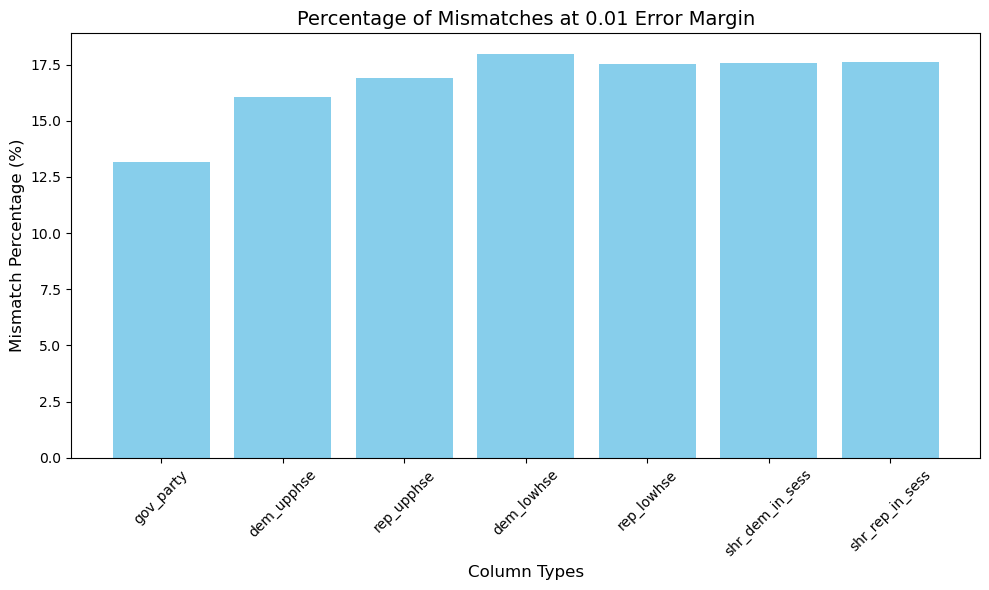

In [41]:
# Plot the graph
plt.figure(figsize=(10, 6))
plt.bar(col_types, mismatch_percentages, color='skyblue')
plt.title("Percentage of Mismatches at 0.01 Error Margin", fontsize=14)
plt.xlabel("Column Types", fontsize=12)
plt.ylabel("Mismatch Percentage (%)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

In [42]:
# Define the error margin
error_margin = 0.1

# Compare each pair of _klarner and _icpsr columns
for klarner_col, icpsr_col in zip(klarner_cols, icpsr_cols):
    # Check for mismatched rows within the error margin
    mismatched_rows = merged[~np.isclose(merged[klarner_col], merged[icpsr_col], atol=error_margin)]
    
    # Exclude rows where both are NaN
    mismatched_rows = mismatched_rows[
        ~(merged[klarner_col].isna() & merged[icpsr_col].isna())
    ]
    
    # Store the mismatches in the dictionary
    comparison_results[f"{klarner_col} vs {icpsr_col}"] = mismatched_rows[['year', 'state_abbrev', klarner_col, icpsr_col]]


/var/folders/6h/20f1xzjj5xx3z0lxd2hqpjzc0000gp/T/ipykernel_9118/2829053057.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mismatched_rows = mismatched_rows[
/var/folders/6h/20f1xzjj5xx3z0lxd2hqpjzc0000gp/T/ipykernel_9118/2829053057.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mismatched_rows = mismatched_rows[
/var/folders/6h/20f1xzjj5xx3z0lxd2hqpjzc0000gp/T/ipykernel_9118/2829053057.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mismatched_rows = mismatched_rows[
/var/folders/6h/20f1xzjj5xx3z0lxd2hqpjzc0000gp/T/ipykernel_9118/2829053057.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mismatched_rows = mismatched_rows[
/var/folders/6h/20f1xzjj5xx3z0lxd2hqpjzc0000gp/T/ipykernel_9118/2829053057.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mismatched_rows = mismatched_rows[
/var/folders/6h/20f1xzjj5

In [43]:
# At 0.01 error margin, the percentage of mismatches is less than 20% for all columns. 
# Not fantastic but passable given the quality of ICPSR data, and the fact that all errors 
# are propagated by forward-filling.
col_types = ['gov_party', 'dem_upphse', 'rep_upphse', 'dem_lowhse', 'rep_lowhse', 'shr_dem_in_sess', 'shr_rep_in_sess']
mismatch_percentages = []  # To store mismatch percentages

for col_type in col_types:
    mismatched_data = comparison_results[f'{col_type}_klarner vs {col_type}_icpsr']
    percentage_mismatch = mismatched_data.shape[0] / merged.shape[0] * 100
    mismatch_percentages.append(percentage_mismatch)
    print(f"Percentage of mismatches At 0.01 error margin:")
    print(f"There are {mismatched_data.shape[0]} {col_type} mismatches.")
    print(f"So for {col_type} there are {percentage_mismatch:.1f}% of data mismatched.")

Percentage of mismatches At 0.01 error margin:
There are 270 gov_party mismatches.
So for gov_party there are 13.2% of data mismatched.
Percentage of mismatches At 0.01 error margin:
There are 111 dem_upphse mismatches.
So for dem_upphse there are 5.4% of data mismatched.
Percentage of mismatches At 0.01 error margin:
There are 114 rep_upphse mismatches.
So for rep_upphse there are 5.6% of data mismatched.
Percentage of mismatches At 0.01 error margin:
There are 127 dem_lowhse mismatches.
So for dem_lowhse there are 6.2% of data mismatched.
Percentage of mismatches At 0.01 error margin:
There are 128 rep_lowhse mismatches.
So for rep_lowhse there are 6.2% of data mismatched.
Percentage of mismatches At 0.01 error margin:
There are 114 shr_dem_in_sess mismatches.
So for shr_dem_in_sess there are 5.6% of data mismatched.
Percentage of mismatches At 0.01 error margin:
There are 117 shr_rep_in_sess mismatches.
So for shr_rep_in_sess there are 5.7% of data mismatched.


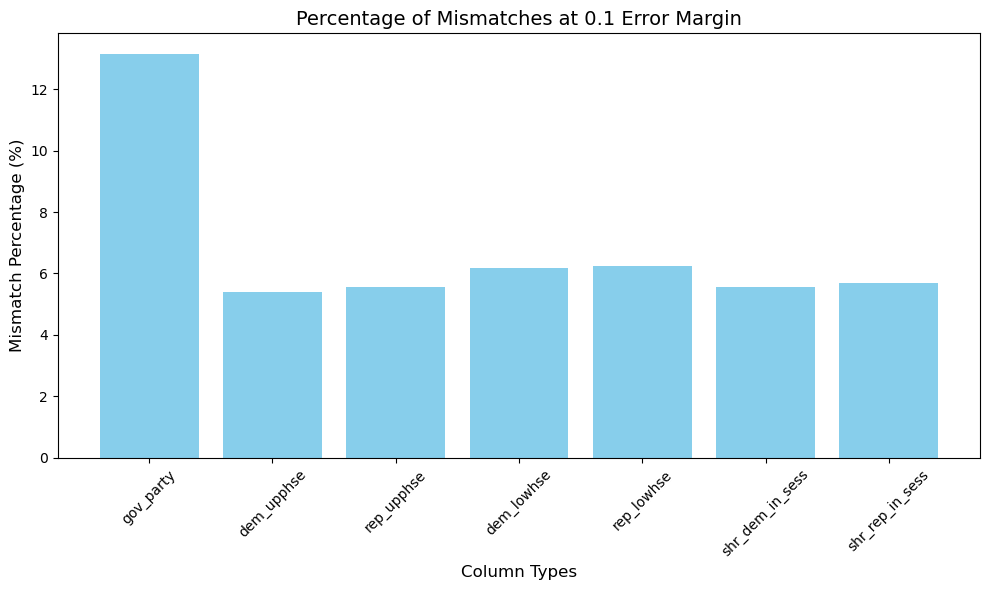

In [44]:
# Plot the graph
plt.figure(figsize=(10, 6))
plt.bar(col_types, mismatch_percentages, color='skyblue')
plt.title("Percentage of Mismatches at 0.1 Error Margin", fontsize=14)
plt.xlabel("Column Types", fontsize=12)
plt.ylabel("Mismatch Percentage (%)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

To conclude, we can see that the forward-filling works but it propagates missing values and errors in the data of which there are plenty in the ICPSR 16 dataset. I will use separate governor's data to ensure accuracy for governors. I will use more accurate Klarner dataset for after 1935. It's not ideal but it's the best we have.

# Forward filling ICPSR data for before 1935

In [45]:
icpsr_filt = icpsr[icpsr['year'] <= 1935]

In [46]:
# Create a complete grid of years and states
years = icpsr_filt['year'].unique()
states = icpsr_filt['state_abbrev'].unique()

# Create a DataFrame with all combinations
all_combos = pd.MultiIndex.from_product([years, states], names=['year', 'state_abbrev']).to_frame(index=False)

print(all_combos.head())

   year state_abbrev
0  1834           CT
1  1834           ME
2  1834           MA
3  1834           NH
4  1834           RI


In [47]:
statehood_df = pd.read_csv(os.path.join(raw_data_dir, "statehood", "statehood_data.csv"))

# Extract the year from 'date_entered' and store it in a new column 'year'
statehood_df['statehood_year'] = statehood_df['date_entered'].str.extract(r'(\d{4})').astype(int)

# Rename 'abbr' to 'state_abbrev'
statehood_df = statehood_df.rename(columns={'abbr': 'state_abbrev'})

# Keep only 'year' and 'state_abbrev' columns
statehood_df = statehood_df[['statehood_year', 'state_abbrev']]

# Display the cleaned DataFrame
print(statehood_df.head())

statehood_df2 = statehood_df.copy()

statehood_df2['statehood_year'] = statehood_df2['statehood_year'] - 1

# Display the cleaned DataFrame
print(statehood_df2.head())

   statehood_year state_abbrev
0            1787           DE
1            1787           PA
2            1787           NJ
3            1788           GA
4            1788           CT
   statehood_year state_abbrev
0            1786           DE
1            1786           PA
2            1786           NJ
3            1787           GA
4            1787           CT


In [48]:
# Merge the statehood data to filter by valid years
all_combos = all_combos.merge(statehood_df2, on='state_abbrev', how='left')

In [49]:
# Keep only rows where the year is greater than or equal to the statehood year
all_combos = all_combos[all_combos['year'] >= all_combos['statehood_year']].drop(columns=['statehood_year'])

In [50]:
# Merge the complete grid with the original dataset
icpsr_complete = pd.merge(all_combos, icpsr_filt, on=['year', 'state_abbrev'], how='left')

print(
    icpsr_complete[icpsr_complete['state_abbrev'] == 'AZ']
    [['year', 'state_abbrev', 'gov_party', 'rep_upphse']]
    .sort_values(by='year', ascending=True)
    .head()
)

# Identify identifier columns (e.g., year and state_abbrev)
id_cols = ['year', 'state_abbrev']
gov_id_cols = ['year', 'state_abbrev', 'gov_party']

# Identify non-identifier columns
non_id_cols = [col for col in icpsr_complete.columns if col not in id_cols]
non_gov_id_cols = [col for col in icpsr_complete.columns if col not in gov_id_cols]

# Forward-fill for each state
for state in states:
    # Subset the data for the current state and sort by year
    state_data = icpsr_complete[icpsr_complete['state_abbrev'] == state].sort_values(by='year')
    
    # Forward-fill non-identifier columns
    state_data[non_id_cols] = state_data[non_id_cols].ffill()
    
    # Forward-fill non-gov_party columns
    state_data[non_gov_id_cols] = state_data[non_gov_id_cols].ffill()
    
    # Update the main DataFrame
    icpsr_complete.loc[state_data.index, non_id_cols] = state_data[non_id_cols]
    icpsr_complete.loc[state_data.index, non_gov_id_cols] = state_data[non_gov_id_cols]

# Display results for AZ
print(
    icpsr_complete[icpsr_complete['state_abbrev'] == 'AZ']
    [['year', 'state_abbrev', 'gov_party', 'rep_upphse']]
    .sort_values(by='year', ascending=True)
    .head()
)

      year state_abbrev  gov_party  rep_upphse
3147  1911           AZ        1.0    0.052632
2327  1912           AZ        NaN         NaN
3195  1913           AZ        NaN         NaN
2375  1914           AZ        1.0    0.052632
3243  1915           AZ        NaN         NaN
      year state_abbrev  gov_party  rep_upphse
3147  1911           AZ        1.0    0.052632
2327  1912           AZ        1.0    0.052632
3195  1913           AZ        1.0    0.052632
2375  1914           AZ        1.0    0.052632
3243  1915           AZ        1.0    0.052632


In [51]:
# Assertions
assert icpsr_complete['state_abbrev'].nunique() == 48, "There should be 48 states because the data is before 1935."
assert icpsr_complete['year'].min() == 1834, "The minimum year should be 1834."
assert icpsr_complete['year'].max() == 1935, "The maximum year should be 1935."
assert icpsr_complete['year'].nunique() == 102, "There should be 102 unique years."

assert icpsr_complete['gov_party'].nunique() == 2, "There should be 2 unique parties."

# Check if all values in 'gov_party' are valid
valid_values = {1, 2}  
assert icpsr_complete['gov_party'].dropna().isin(valid_values).all(), "All values in 'gov_party' should be 1, 2, or NaN."

# Uploading ncsl_state_composition data

PDF is the only format in which the data is available on ncsl website. I first extracted those files into excel format using Adobe Pdf Extraction tool which can be found here: https://www.adobe.com/au/acrobat/roc/blog/how-to-convert-pdf-to-csv.html#:~:text=Adobe%20Acrobat%20online%20services The free tool does not allow bulk extraction. MIT account gives access to upgraded tool with extraction. I then removed the first row manually and everything after "TOTAL" field. 

In [52]:
# Folder path where CSV files are stored
folder_path = os.path.join(raw_data_dir, "ncsl_statepartisancomposition")
assert os.path.exists(folder_path), "Folder path is incorrect"

# List all CSV files in the folder
xlsx_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.xlsx') and not f.startswith('~$')])

# Efficiently load and concatenate all excel files
ncsl_dfs = []  # List to hold individual DataFrames
for file in tqdm(xlsx_files):
       file_path = os.path.join(folder_path, file)
       assert os.path.exists(file_path), "File path is incorrect"

       # Extract year from the filename (before ".xlsx")
       year = int(file.split('.xlsx')[0])

       # Extract tables from the PDF file
       ncsl_df = pd.read_excel(file_path)

       if file != '2021.xlsx':
              ncsl_df.columns = ['state', 'total_seats', 'total_senate', 'senate_dem', 'senate_rep',
              'senate_other', 'total_house', 'house_dem', 'house_rep', 'house_other',
              'legis_control', 'gov_party', 'state_control']
              # Drop columns called 'senate_other' and 'house_other'
              ncsl_df = ncsl_df.drop(columns=['senate_other', 'house_other'])
              # ncsl_df.head()
       else:
              # Rename columns manually
              ncsl_df.columns = ['state', 'total_seats', 'total_senate', 'senate_dem', 'senate_rep',
                     'total_house', 'house_dem', 'house_rep', 'legis_control', 'gov_party', 'state_control']
              # ncsl_df.head()

       # Remove asterisks from state names in the 'State' column
       ncsl_df['state'] = ncsl_df['state'].str.replace(r'\*', '', regex=True)

       # Add the extracted year as a new column 
       ncsl_df['year'] = year 

       # Append the modified DataFrame to the list
       ncsl_dfs.append(ncsl_df)

       print(f"Completed processing {file}")

# Concatenate all DataFrames into one
ncsl = pd.concat(ncsl_dfs, ignore_index=True)

print(ncsl.columns)

# Add a new column to the DataFrame with the abbreviations
ncsl.loc[:, 'state_abbrev'] = ncsl['state'].map(state_to_abbrev)

# Recoding the 'gov_party' column to match ICPSR data
ncsl['gov_party'] = ncsl['gov_party'].map({'Dem': 1, 'Rep': 2})

# Since in ICPSR I only have state abbreviations, I will drop the column containing the full state names
ncsl = ncsl.drop(columns=['state'])

ncsl = ncsl.dropna(subset=['state_abbrev'])

# Reorder the columns to have identifiers first
ncsl = ncsl[['year', 'state_abbrev', 'total_seats', 'total_senate', 'senate_dem', 
'senate_rep', 'total_house', 'house_dem', 'house_rep', 'legis_control', 'gov_party', 'state_control']]

  0%|          | 0/13 [00:00<?, ?it/s]

Completed processing 2009.xlsx
Completed processing 2010.xlsx
Completed processing 2011.xlsx
Completed processing 2012.xlsx
Completed processing 2013.xlsx
Completed processing 2014.xlsx
Completed processing 2015.xlsx
Completed processing 2016.xlsx


100%|██████████| 13/13 [00:00<00:00, 77.09it/s]

Completed processing 2017.xlsx
Completed processing 2018.xlsx
Completed processing 2019.xlsx
Completed processing 2020.xlsx
Completed processing 2021.xlsx
Index(['state', 'total_seats', 'total_senate', 'senate_dem', 'senate_rep',
       'total_house', 'house_dem', 'house_rep', 'legis_control', 'gov_party',
       'state_control', 'year'],
      dtype='object')


In [53]:
ncsl.head()

,year,state_abbrev,total_seats,total_senate,senate_dem,senate_rep,total_house,house_dem,house_rep,legis_control,gov_party,state_control
1,2009,AL,140,35,19,13,105,62,43,Dem,2.0,Divided
2,2009,AK,60,20,10,10,40,18,22,Split,2.0,Divided
3,2009,AZ,90,30,12,18,60,25,35,Rep,2.0,Rep
4,2009,AR,135,35,27,8,100,71,28,Dem,1.0,Dem
5,2009,CA,120,40,26,14,80,51,29,Dem,2.0,Divided


In [54]:
# List of columns to convert to numeric
numeric_cols = [
    'total_seats', 'total_senate', 'senate_dem', 'senate_rep', 'total_house', 'house_dem', 'house_rep'
]

# Convert specified columns to numeric
ncsl[numeric_cols] = ncsl[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Verify the conversion
print(ncsl[numeric_cols].dtypes)

ncsl['dem_upphse'] = ncsl['senate_dem'] / ncsl['total_senate']
ncsl['rep_upphse'] = ncsl['senate_rep'] / ncsl['total_senate']
ncsl['dem_lowhse'] = ncsl['house_dem'] / ncsl['total_house']
ncsl['rep_lowhse'] = ncsl['house_rep'] / ncsl['total_house']
ncsl['shr_dem_in_sess'] = (ncsl['senate_dem'] + ncsl['house_dem']) / ncsl['total_seats']
ncsl['shr_rep_in_sess'] = (ncsl['senate_rep'] + ncsl['house_rep']) / ncsl['total_seats']

ncsl = ncsl.drop(columns=['total_seats', 'total_senate', 'senate_dem', 'senate_rep', 'total_house', 'house_dem', 'house_rep', 'legis_control', 'state_control'])

# Now the year is election year
ncsl['year'] = ncsl['year'] - 1


total_seats       int64
total_senate      int64
senate_dem      float64
senate_rep      float64
total_house     float64
house_dem       float64
house_rep       float64
dtype: object


In [55]:
state_count_by_year = ncsl.groupby('year')['state_abbrev'].nunique()

# Assertions
assert (state_count_by_year == 50).all(), "Not all years have 50 states!"
assert ncsl['year'].min() == 2008, "The minimum year should be 2008."
assert ncsl['year'].max() == 2020, "The maximum year should be 2020."
assert ncsl['year'].nunique() == 13, "There should be 12 unique years."

assert ncsl['gov_party'].nunique() == 2, "There should be 2 unique parties."

# Check if all values in 'gov_party' are valid
valid_values = {1, 2}  
assert ncsl['gov_party'].dropna().isin(valid_values).all(), "All values in 'gov_party' should be 1, 2, or NaN."

## Double-check that Klarner and NCSL align for 2009-2010

In [56]:
ncsl_filt = ncsl[(ncsl['year'] <= 2010)]
klarner_filt = klarner1[klarner1['year'] >= 2008]

print(f"Years in ncsl: {ncsl_filt['year'].unique()}")
print(f"Years in klarner: {klarner_filt['year'].unique()}")

Years in ncsl: [2008 2009 2010]
Years in klarner: [2008 2009 2010]


In [57]:
merged = pd.merge(klarner_filt, ncsl_filt, on=['year', 'state_abbrev'], suffixes=('_klarner', '_ncsl'), how='outer')

In [58]:
# Identify all columns with '_klarner' and '_ncsl' suffixes
klarner_cols = [col for col in merged.columns if col.endswith('_klarner')]
ncsl_cols = [col.replace('_klarner', '_ncsl') for col in klarner_cols if col.replace('_klarner', '_ncsl') in merged.columns]

# Initialize a dictionary to store comparison results
comparison_results = {}

# Define the error margin
error_margin = 0.1

# Compare each pair of _klarner and _ncsl columns
for klarner_col, ncsl_col in zip(klarner_cols, ncsl_cols):
    # Check for mismatched rows within the error margin
    mismatched_rows = merged[~np.isclose(merged[klarner_col], merged[ncsl_col], atol=error_margin)]
    
    # Exclude rows where both are NaN
    mismatched_rows = mismatched_rows[
        ~(merged[klarner_col].isna() & merged[ncsl_col].isna())
    ]
    
    # Store the mismatches in the dictionary
    comparison_results[f"{klarner_col} vs {ncsl_col}"] = mismatched_rows[['year', 'state_abbrev', klarner_col, ncsl_col]]


/var/folders/6h/20f1xzjj5xx3z0lxd2hqpjzc0000gp/T/ipykernel_9118/600132105.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mismatched_rows = mismatched_rows[
/var/folders/6h/20f1xzjj5xx3z0lxd2hqpjzc0000gp/T/ipykernel_9118/600132105.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mismatched_rows = mismatched_rows[
/var/folders/6h/20f1xzjj5xx3z0lxd2hqpjzc0000gp/T/ipykernel_9118/600132105.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mismatched_rows = mismatched_rows[
/var/folders/6h/20f1xzjj5xx3z0lxd2hqpjzc0000gp/T/ipykernel_9118/600132105.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mismatched_rows = mismatched_rows[
/var/folders/6h/20f1xzjj5xx3z0lxd2hqpjzc0000gp/T/ipykernel_9118/600132105.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mismatched_rows = mismatched_rows[
/var/folders/6h/20f1xzjj5xx3z0

In [59]:
# At 0.1 error margin, the percentage of mismatches is 0 for all columns except gov_party.
col_types = ['gov_party', 'dem_upphse', 'rep_upphse', 'dem_lowhse', 'rep_lowhse', 'shr_dem_in_sess', 'shr_rep_in_sess']
mismatch_percentages = []
for col_type in col_types:
    # Access mismatched data
    mismatched_data = comparison_results.get(f'{col_type}_klarner vs {col_type}_ncsl', pd.DataFrame())
    
    # Calculate mismatch percentage if mismatched_data is not empty
    if not mismatched_data.empty:
        percentage_mismatch = mismatched_data.shape[0] / merged.shape[0] * 100
        mismatch_percentages.append(percentage_mismatch)
        print(f"Percentage of mismatches At 0.01 error margin:")
        print(f"There are {mismatched_data.shape[0]} {col_type} mismatches.")
        print(f"So for {col_type} there are {percentage_mismatch:.1f}% of data is mismatched.")
    else:
        # Append 0% for columns with no mismatches
        mismatch_percentages.append(0)


Percentage of mismatches At 0.01 error margin:
There are 1 gov_party mismatches.
So for gov_party there are 0.7% of data is mismatched.


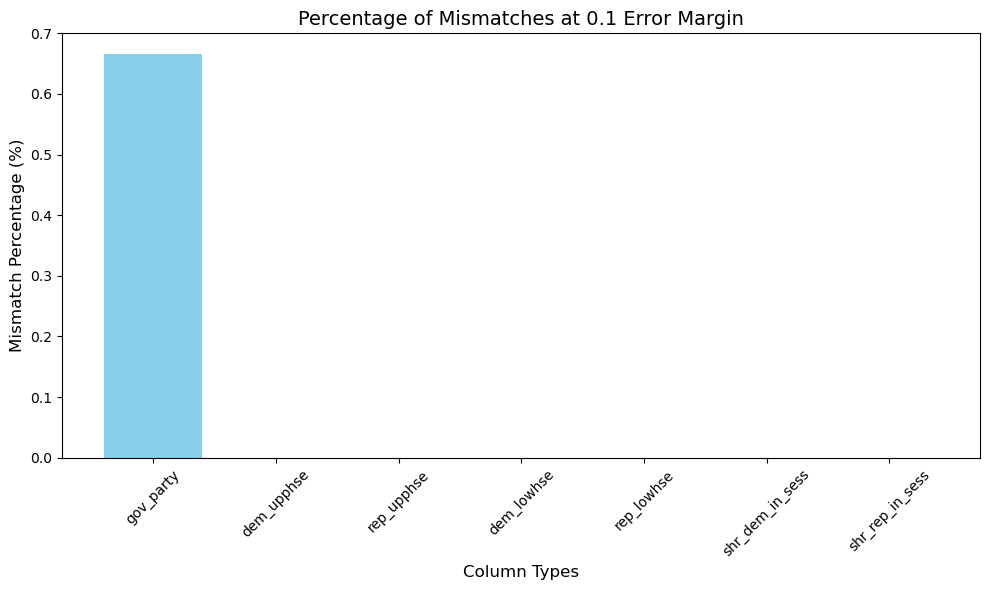

In [60]:
# Plot the graph
plt.figure(figsize=(10, 6))
plt.bar(col_types, mismatch_percentages, color='skyblue')
plt.title("Percentage of Mismatches at 0.1 Error Margin", fontsize=14)
plt.xlabel("Column Types", fontsize=12)
plt.ylabel("Mismatch Percentage (%)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

In [61]:
# Define the error margin
error_margin = 0.01

# Compare each pair of _klarner and _ncsl columns
for klarner_col, ncsl_col in zip(klarner_cols, ncsl_cols):
    # Check for mismatched rows within the error margin
    mismatched_rows = merged[~np.isclose(merged[klarner_col], merged[ncsl_col], atol=error_margin)]
    
    # Exclude rows where both are NaN
    mismatched_rows = mismatched_rows[
        ~(merged[klarner_col].isna() & merged[ncsl_col].isna())
    ]
    
    # Store the mismatches in the dictionary
    comparison_results[f"{klarner_col} vs {ncsl_col}"] = mismatched_rows[['year', 'state_abbrev', klarner_col, ncsl_col]]


/var/folders/6h/20f1xzjj5xx3z0lxd2hqpjzc0000gp/T/ipykernel_9118/1914774426.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mismatched_rows = mismatched_rows[
/var/folders/6h/20f1xzjj5xx3z0lxd2hqpjzc0000gp/T/ipykernel_9118/1914774426.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mismatched_rows = mismatched_rows[
/var/folders/6h/20f1xzjj5xx3z0lxd2hqpjzc0000gp/T/ipykernel_9118/1914774426.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mismatched_rows = mismatched_rows[
/var/folders/6h/20f1xzjj5xx3z0lxd2hqpjzc0000gp/T/ipykernel_9118/1914774426.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mismatched_rows = mismatched_rows[
/var/folders/6h/20f1xzjj5xx3z0lxd2hqpjzc0000gp/T/ipykernel_9118/1914774426.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  mismatched_rows = mismatched_rows[
/var/folders/6h/20f1xzjj5

In [62]:
# At 0.01 error margin, the percentage of mismatches is less than 10% for all columns except gov_party.
col_types = ['gov_party', 'dem_upphse', 'rep_upphse', 'dem_lowhse', 'rep_lowhse', 'shr_dem_in_sess', 'shr_rep_in_sess']
mismatch_percentages = []
for col_type in col_types:
    # Access mismatched data
    mismatched_data = comparison_results.get(f'{col_type}_klarner vs {col_type}_ncsl', pd.DataFrame())
    
    # Calculate mismatch percentage if mismatched_data is not empty
    if not mismatched_data.empty:
        percentage_mismatch = mismatched_data.shape[0] / merged.shape[0] * 100
        mismatch_percentages.append(percentage_mismatch)
        print(f"Percentage of mismatches At 0.01 error margin:")
        print(f"There are {mismatched_data.shape[0]} {col_type} mismatches.")
        print(f"So for {col_type} there are {percentage_mismatch:.1f}% of data is mismatched.")
    else:
        # Append 0% for columns with no mismatches
        mismatch_percentages.append(0)


Percentage of mismatches At 0.01 error margin:
There are 1 gov_party mismatches.
So for gov_party there are 0.7% of data is mismatched.
Percentage of mismatches At 0.01 error margin:
There are 11 dem_upphse mismatches.
So for dem_upphse there are 7.3% of data is mismatched.
Percentage of mismatches At 0.01 error margin:
There are 8 rep_upphse mismatches.
So for rep_upphse there are 5.3% of data is mismatched.
Percentage of mismatches At 0.01 error margin:
There are 10 dem_lowhse mismatches.
So for dem_lowhse there are 6.7% of data is mismatched.
Percentage of mismatches At 0.01 error margin:
There are 9 rep_lowhse mismatches.
So for rep_lowhse there are 6.0% of data is mismatched.
Percentage of mismatches At 0.01 error margin:
There are 6 shr_dem_in_sess mismatches.
So for shr_dem_in_sess there are 4.0% of data is mismatched.
Percentage of mismatches At 0.01 error margin:
There are 7 shr_rep_in_sess mismatches.
So for shr_rep_in_sess there are 4.7% of data is mismatched.


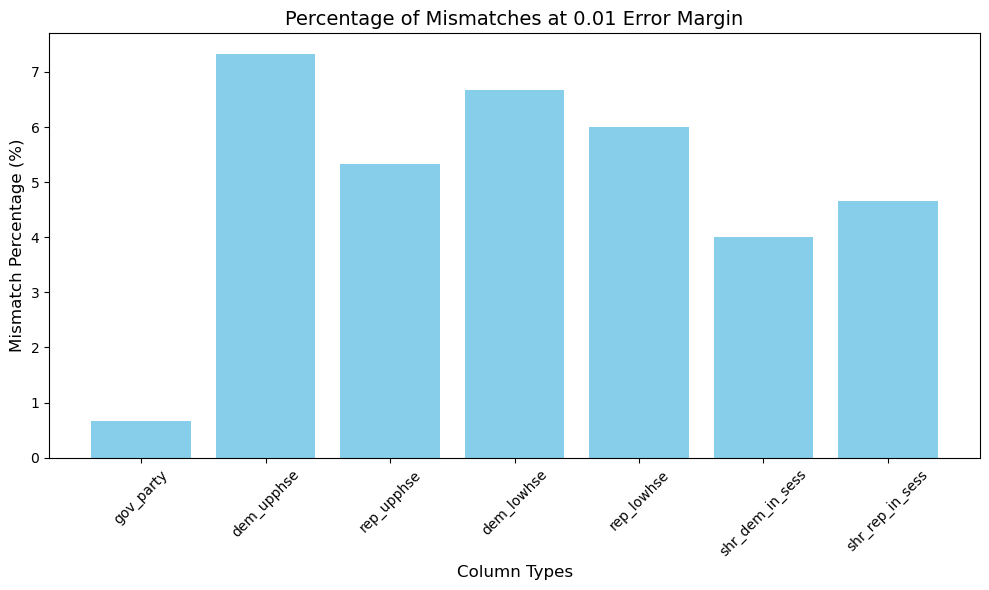

In [63]:
# Plot the graph
plt.figure(figsize=(10, 6))
plt.bar(col_types, mismatch_percentages, color='skyblue')
plt.title("Percentage of Mismatches at 0.01 Error Margin", fontsize=14)
plt.xlabel("Column Types", fontsize=12)
plt.ylabel("Mismatch Percentage (%)", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

In [64]:
comparison_results['gov_party_klarner vs gov_party_ncsl'] 

,year,state_abbrev,gov_party_klarner,gov_party_ncsl
94,2009,VA,1.0,2.0


In 2009, the Governor of Virginia was Tim Kaine, a member of the Democratic Party. He served as governor from January 14, 2006, to January 16, 2010 thus it is a mistake in ncsl dataset. However 1 mistake in 3 years is great. 

# Concatinate all the data
Concatinating icpsr_complete (1832-1934), Klarner1 (1935-2010), ncsl (2011-2020)

In [65]:
ncsl = ncsl[ncsl['year'] > 2010]
klarner1 = klarner1[klarner1['year'] > 1935]

In [66]:
final_df = pd.concat([icpsr_complete, klarner1, ncsl], ignore_index=True)

In [67]:
# Assertions
assert final_df['year'].min() == 1834, "The minimum year should be 2008."
assert final_df['year'].max() == 2020, "The maximum year should be 2020."
assert final_df['year'].nunique() == 187, "There should be 12 unique years."

assert final_df['gov_party'].nunique() == 2, "There should be 2 unique parties."

# Check if all values in 'gov_party' are valid
valid_values = {1, 2}  
assert final_df['gov_party'].dropna().isin(valid_values).all(), "All values in 'gov_party' should be 1, 2, or NaN."

In [68]:
statehood_df.head()

,statehood_year,state_abbrev
0,1787,DE
1,1787,PA
2,1787,NJ
3,1788,GA
4,1788,CT


In [69]:
final_df['year'].value_counts().head(3)

year
1974    51
2020    50
1967    50
Name: count, dtype: int64

In [70]:
print(final_df[final_df['year'] == 1974]['state_abbrev'].value_counts().head(2))
# Clearly the problem is that we have two Louisianas in 1974.

state_abbrev
LA    2
AL    1
Name: count, dtype: int64


In [71]:
print(final_df[(final_df['state_abbrev'] == 'LA') & (final_df['year'] == 1974)])

      year state_abbrev  gov_party  dem_upphse  rep_upphse  dem_lowhse  \
4746  1974           LA        1.0    0.974359    0.025641    0.961905   
4747  1974           LA        1.0    0.974359    0.000000    0.961905   

      rep_lowhse  shr_dem_in_sess  shr_rep_in_sess  
4746    0.038095         0.965278         0.034722  
4747    0.038095         0.965278         0.027778  


I cross-references both Louisianas against wikipedia: https://en.wikipedia.org/wiki/Political_party_strength_in_Louisiana, and I can see that both are wrong so I am going to substitute them with the correct version

In [72]:
# Remove the two original observations for Louisiana in 1974
final_df = final_df[~((final_df['year'] == 1974) & (final_df['state_abbrev'] == 'LA'))]

# Total members in Senate and House
total_senate = 39
total_house = 105
total_members = total_senate + total_house

# Calculate the new values for shr_dem_in_session and shr_rep_in_session
shr_dem_in_sess = (1 * total_senate + 0.961905 * total_house) / total_members
shr_rep_in_sess = (0 * total_senate + 0.038095 * total_house) / total_members

# Create a new observation for Louisiana in 1974
new_observation = pd.DataFrame([{
    'year': 1974,
    'state_abbrev': 'LA',
    'gov_party': 1.0,  # Preserved from the original
    'dem_upphse': 1.0,  # Adjusted to 1
    'rep_upphse': 0.0,  # Adjusted to 0
    'dem_lowhse': 0.961905,  # Preserved from the original
    'rep_lowhse': 0.038095,  # Preserved from the original
    'shr_dem_in_sess': shr_dem_in_sess,
    'shr_rep_in_sess': shr_rep_in_sess
}])

# Append the new observation to final_df using pd.concat
final_df = pd.concat([final_df, new_observation], ignore_index=True)

# Display the result for Louisiana in 1974
print(final_df[(final_df['year'] == 1974) & (final_df['state_abbrev'] == 'LA')])

      year state_abbrev  gov_party  dem_upphse  rep_upphse  dem_lowhse  \
8243  1974           LA        1.0         1.0         0.0    0.961905   

      rep_lowhse  shr_dem_in_sess  shr_rep_in_sess  
8243    0.038095         0.972222         0.027778  


In [73]:
# Add the index as a column, starting from 1
statehood_df1 = statehood_df.reset_index(drop=False)
statehood_df1['index'] = statehood_df1['index'] + 1

# Sort the DataFrame by 'statehood_year' and 'index' (if not already sorted)
statehood_df1 = statehood_df1.sort_values(by=['statehood_year', 'index'])

# Drop all rows except the last one for each 'statehood_year'
statehood_df1 = statehood_df1.groupby('statehood_year', group_keys=False).tail(1)

# Define the full range of years
full_years = pd.DataFrame({'statehood_year': range(1787, 2022)})

# Merge with the existing DataFrame to include all years
statehood_df1 = pd.merge(full_years, statehood_df1, on='statehood_year', how='left')

# Forward-fill to propagate the last known index value to missing years
statehood_df1['index'] = statehood_df1['index'].ffill()
statehood_df1['state_abbrev'] = statehood_df1['state_abbrev'].ffill()

# Ensure the DataFrame is sorted by year
statehood_df1 = statehood_df1.sort_values(by='statehood_year').reset_index(drop=True)

statehood_df1 = statehood_df1.drop(columns=['state_abbrev'])

statehood_df1 = statehood_df1.rename(columns={'index': 'state_count', 'statehood_year': 'year'})

statehood_df1['year'] = statehood_df1['year'] - 1

num_of_states = statehood_df1[statehood_df1['year'] >= 1834]

In [74]:
num_of_states_final = final_df['year'].value_counts()

merged_num_of_states = pd.merge(num_of_states, num_of_states_final, on='year', how='outer')

merged_num_of_states = merged_num_of_states.rename(
    columns={
        'state_count': 'num_states_statehood',  
        'count': 'num_states_final'           
    }
)
print(merged_num_of_states.head(3))
print(merged_num_of_states.columns)

# Check if the columns align
mismatched_rows = merged_num_of_states[
    merged_num_of_states['num_states_statehood'] != merged_num_of_states['num_states_final']
]

# Display the mismatched rows with all relevant columns
print(mismatched_rows.shape[0])
print(mismatched_rows[['year', 'num_states_statehood', 'num_states_final']].sort_values(by='year'))

   year  num_states_statehood  num_states_final
0  1834                  24.0                24
1  1835                  25.0                25
2  1836                  26.0                26
Index(['year', 'num_states_statehood', 'num_states_final'], dtype='object')
10
     year  num_states_statehood  num_states_final
114  1948                  48.0                50
115  1949                  48.0                50
116  1950                  48.0                50
117  1951                  48.0                50
118  1952                  48.0                50
119  1953                  48.0                50
120  1954                  48.0                50
121  1955                  48.0                50
122  1956                  48.0                50
123  1957                  48.0                50


In [75]:
klarner1_0[(klarner1_0['year'] >= 1948) & (klarner1_0['year'] < 1959)]['year'].value_counts().sort_index()

year
1948    50
1949    50
1950    50
1951    50
1952    50
1953    50
1954    50
1955    50
1956    50
1957    50
1958    50
Name: count, dtype: int64

In [76]:
klarner_AK_HI = klarner1[klarner1['state_abbrev'].isin(['AK', 'HI'])]

In [77]:
klarner_AK_HI[(klarner_AK_HI['year'] >= 1948) & (klarner_AK_HI['year'] < 1958)]

,year,state_abbrev,gov_party,dem_upphse,rep_upphse,dem_lowhse,rep_lowhse,shr_dem_in_sess,shr_rep_in_sess
54,1952,AK,NaN,0.312500,0.687500,0.166667,0.833333,0.225000,0.775000
55,1953,AK,NaN,0.312500,0.687500,0.166667,0.833333,0.225000,0.775000
56,1954,AK,NaN,0.687500,0.250000,0.875000,0.125000,0.800000,0.175000
57,1955,AK,NaN,0.687500,0.250000,0.875000,0.125000,0.800000,0.175000
58,1956,AK,NaN,0.687500,0.312500,0.875000,0.125000,0.800000,0.200000
59,1957,AK,NaN,0.687500,0.312500,0.875000,0.125000,0.800000,0.200000
405,1948,HI,NaN,0.333333,0.666667,0.333333,0.666667,0.333333,0.666667
406,1949,HI,NaN,0.333333,0.666667,0.333333,0.666667,0.333333,0.666667
407,1950,HI,NaN,0.400000,0.600000,0.300000,0.700000,0.333333,0.666667
408,1951,HI,NaN,0.400000,0.600000,0.300000,0.700000,0.333333,0.666667


In [78]:
klarner_AK_HI[klarner_AK_HI['year'] >= 1958].head(10)

,year,state_abbrev,gov_party,dem_upphse,rep_upphse,dem_lowhse,rep_lowhse,shr_dem_in_sess,shr_rep_in_sess
60,1958,AK,1.0,0.90,0.10,0.850,0.125,0.866667,0.116667
61,1959,AK,1.0,0.90,0.10,0.850,0.125,0.866667,0.116667
62,1960,AK,1.0,0.70,0.30,0.550,0.450,0.600000,0.400000
63,1961,AK,1.0,0.65,0.35,0.550,0.450,0.583333,0.416667
64,1964,AK,1.0,0.85,0.15,0.750,0.250,0.783333,0.216667
65,1965,AK,1.0,0.85,0.15,0.750,0.250,0.783333,0.216667
66,1966,AK,2.0,0.30,0.70,0.375,0.625,0.350000,0.650000
67,1967,AK,2.0,0.30,0.70,0.375,0.625,0.350000,0.650000
68,2002,AK,2.0,0.40,0.60,0.325,0.675,0.350000,0.650000
69,2003,AK,2.0,0.40,0.60,0.325,0.675,0.350000,0.650000


In [79]:
# It seems like the inclusion of AK and HI for before 1958 is a mistake in the Klarner dataset.

# Remove rows for AK and HI before 1958 from the final dataset
final_df = final_df[~((final_df['state_abbrev'].isin(['AK', 'HI'])) & (final_df['year'] < 1958))]

In [80]:
num_of_states_final = final_df['year'].value_counts()

merged_num_of_states = pd.merge(num_of_states, num_of_states_final, on='year', how='outer')

merged_num_of_states = merged_num_of_states.rename(
    columns={
        'state_count': 'num_states_statehood',  
        'count': 'num_states_final'           
    }
)
print(merged_num_of_states.head(3))
print(merged_num_of_states.columns)

# Assert that the number of states in the final data aligns with the reality
assert (merged_num_of_states['num_states_statehood'] == merged_num_of_states['num_states_final']).all(), "Mismatch found between num_states_statehood and num_states_final"

   year  num_states_statehood  num_states_final
0  1834                  24.0                24
1  1835                  25.0                25
2  1836                  26.0                26
Index(['year', 'num_states_statehood', 'num_states_final'], dtype='object')


In [81]:
final_df.to_csv(os.path.join(intermed_data_dir, 'state_politicalComposition.csv'), index=False)

## Compare with governors data
Generated in cleaning_govData.ipynb

In [82]:
gov_data = os.path.join(raw_data_dir, "gov_data_cleaned.csv")

In [117]:
regions = pd.read_csv(os.path.join(raw_data_dir, "state_regions.csv"))

regions.rename(columns={'State Code': 'state_abbrev', 'Region': 'region', 'Division':'division'}, inplace=True)
regions = regions.drop(columns=['State'])

In [121]:
final_merged = pd.merge(final_df, pd.read_csv(gov_data), on=['year', 'state_abbrev'], how='left', suffixes=('_final', '_gov'))
final_merged = pd.merge(final_merged, regions, on='state_abbrev', how='left')

In [122]:
final_merged.head()

,year,state_abbrev,gov_party_final,dem_upphse,rep_upphse,dem_lowhse,rep_lowhse,shr_dem_in_sess,shr_rep_in_sess,gov_party_gov,region,division
0,1834,CT,NaN,0.190476,0.809524,0.242718,0.757282,0.237885,0.762115,1.0,Northeast,New England
1,1834,CT,NaN,0.190476,0.809524,0.242718,0.757282,0.237885,0.762115,2.0,Northeast,New England
2,1834,ME,1.0,0.600000,0.400000,0.582353,0.417647,0.584615,0.415385,1.0,Northeast,New England
3,1834,MA,NaN,0.025000,0.825000,0.217391,0.774457,0.198529,0.779412,2.0,Northeast,New England
4,1834,MA,NaN,0.025000,0.825000,0.217391,0.774457,0.198529,0.779412,2.0,Northeast,New England


In [123]:
# Find mismatched rows
mismatched_rows = final_merged[final_merged['gov_party_final'] != final_merged['gov_party_gov']]

mismatched_rows = mismatched_rows[mismatched_rows['year']<2020]
final_df_filt = final_df[final_df['year'] < 2020]

# Exclude rows with NA in either column and find mismatched rows
mismatched_rows_no_NAs = final_merged[
    final_merged['gov_party_final'].notna() &
    final_merged['gov_party_gov'].notna() &
    (final_merged['gov_party_final'] != final_merged['gov_party_gov']) &
    (final_merged['year'] < 2020)
]

final_df_no_NAs = final_df.dropna(subset=['gov_party'])

final_df_no_NAs = final_df_no_NAs[final_df_no_NAs['year'] < 2020]

In [124]:
print(f"Percentage of mismatched rows: {mismatched_rows.shape[0] / final_df.shape[0] * 100:.2f}%")

print(f"Percentage of mismatched rows without NAs: {mismatched_rows_no_NAs.shape[0] / final_df_no_NAs.shape[0] * 100:.2f}%")

Percentage of mismatched rows: 23.10%
Percentage of mismatched rows without NAs: 14.89%


In [126]:
mismatched_rows['region'].unique()

array(['Northeast', 'Midwest', 'South', 'West'], dtype=object)

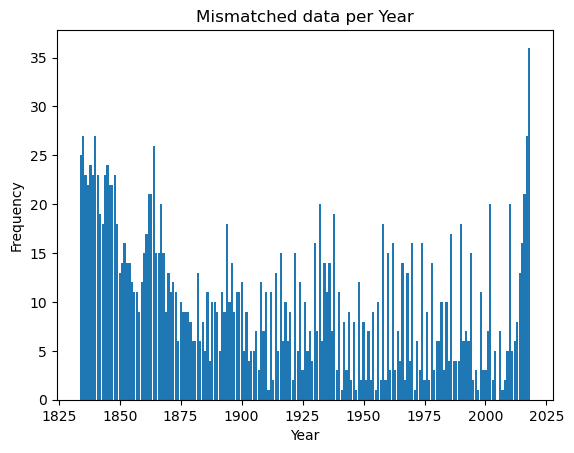

In [132]:
# Count the frequency of observations per year
year_counts = mismatched_rows['year'].value_counts().sort_index()

# Plot the frequency of observations per year
plt.bar(year_counts.index, year_counts.values, width=0.9)
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Mismatched data per Year')
plt.show()

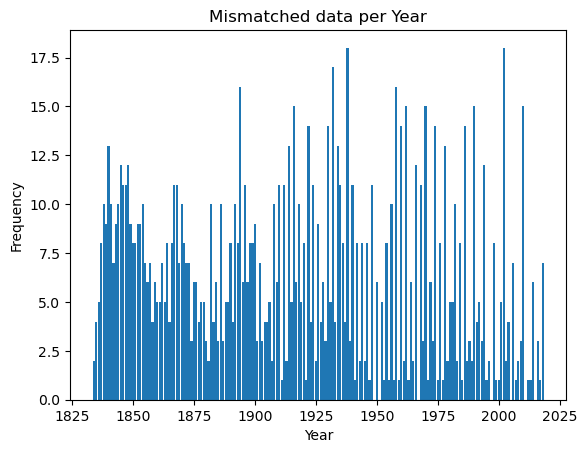

In [133]:
year_counts_no_NAs = mismatched_rows_no_NAs['year'].value_counts().sort_index()

# Plot the frequency of observations per year
plt.bar(year_counts_no_NAs.index, year_counts_no_NAs.values, width=0.9)
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Mismatched data per Year')
plt.show()

In [134]:
final_merged['division'].unique()

array(['New England', 'South Atlantic', 'Middle Atlantic',
       'East North Central', 'West North Central', 'East South Central',
       'West South Central', 'Pacific', 'Mountain'], dtype=object)

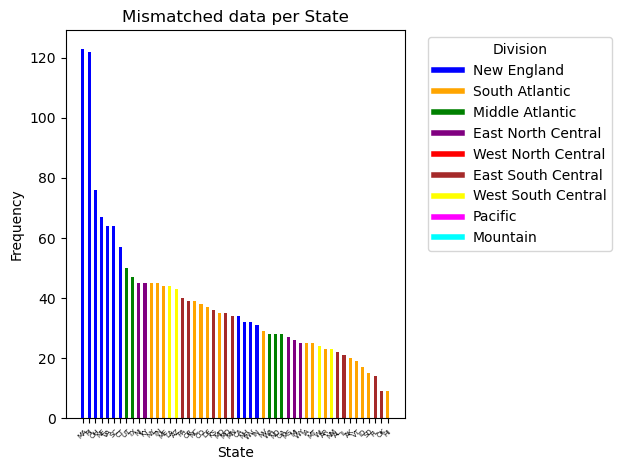

In [140]:
color = 'division'
assert color in ['region', 'division'], "color must be 'region' or 'division'"

# Assign colors based on the 'region' column
if color == 'region':
    region_colors = {
        'South': 'blue', 'West': 'green', 'Northeast': 'orange', 'Midwest': 'purple'
    }

    colors = mismatched_rows['region'].map(region_colors)

# Assign colors based on the 'division' column
if color == "division":
    # Assign colors directly using the 'division' column
    colors = mismatched_rows['division'].map(division_colors)

    # Handle any missing divisions by filling with a default color (e.g., 'gray')
    colors = colors.fillna('gray')


state_counts = mismatched_rows['state_abbrev'].value_counts()

# Plot the frequency of observations per state
plt.bar(state_counts.index, state_counts.values, color = colors, width=0.5)
plt.xlabel('State')
plt.ylabel('Frequency')
plt.title('Mismatched data per State')
plt.xticks(rotation=45, fontsize=5)

# Add legend for divisions
handles = [plt.Line2D([0], [0], color=color, lw=4) for color in division_colors.values()]
labels = division_colors.keys()
plt.legend(handles, labels, title='Division', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

plt.show()

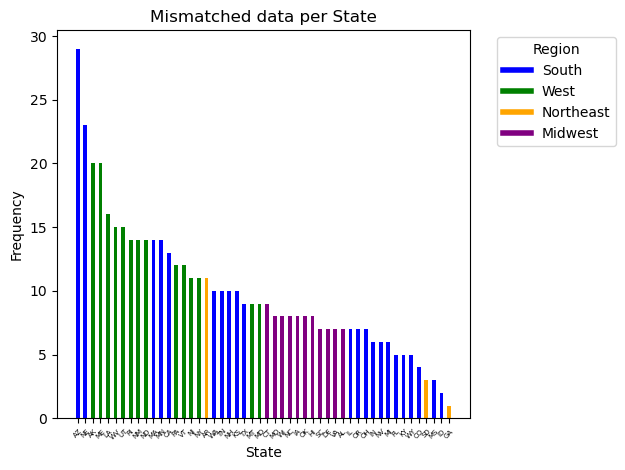

In [144]:
color = 'region'
assert color in ['region', 'division'], "color must be 'region' or 'division'"

mismatched_rows_20 = mismatched_rows[mismatched_rows['year'] > 1959] #When the Hawaii, the last state joined

# Assign colors based on the 'region' column
if color == 'region':
    region_colors = {
        'South': 'blue', 'West': 'green', 'Northeast': 'orange', 'Midwest': 'purple'
    }

    colors = mismatched_rows_20['region'].map(region_colors)

# Assign colors based on the 'division' column
if color == "division":
    # Assign colors directly using the 'division' column
    colors = mismatched_rows_20['division'].map(division_colors)

    # Handle any missing divisions by filling with a default color (e.g., 'gray')
    colors = colors.fillna('gray')


state_counts = mismatched_rows_20['state_abbrev'].value_counts()

# Plot the frequency of observations per state
plt.bar(state_counts.index, state_counts.values, color = colors, width=0.5)
plt.xlabel('State')
plt.ylabel('Frequency')
plt.title('Mismatched data per State')
plt.xticks(rotation=45, fontsize=5)

# Add legend for divisions
if color == 'division':
    handles = [plt.Line2D([0], [0], color=color, lw=4) for color in division_colors.values()]
    labels = division_colors.keys()
    plt.legend(handles, labels, title='Division', bbox_to_anchor=(1.05, 1), loc='upper left')

if color == 'region':
    handles = [plt.Line2D([0], [0], color=color, lw=4) for color in region_colors.values()]
    labels = region_colors.keys()
    plt.legend(handles, labels, title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')


plt.tight_layout()

plt.show()

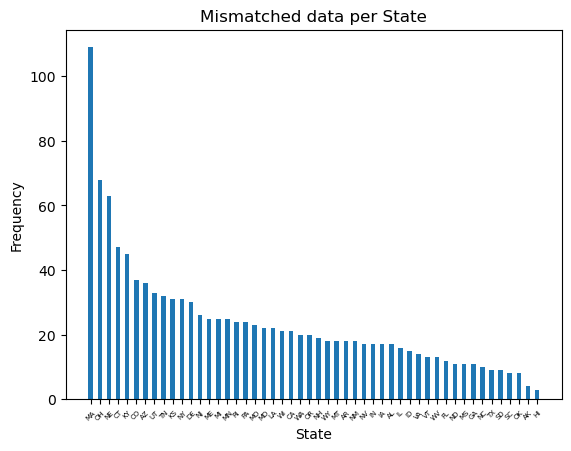

In [113]:
state_counts = mismatched_rows_no_NAs['state_abbrev'].value_counts()

# Plot the frequency of observations per state
plt.bar(state_counts.index, state_counts.values, width=0.5)
plt.xlabel('State')
plt.ylabel('Frequency')
plt.title('Mismatched data per State')
plt.xticks(rotation=45, fontsize=5)
plt.show()

In [118]:
MA_mismatched_rows = mismatched_rows['']

,state_abbrev,region,division
0,AK,West,Pacific
1,AL,South,East South Central
2,AR,South,West South Central
3,AZ,West,Mountain
4,CA,West,Pacific


These results are not great; however, given the ambiguity in classification of regional party affiliations, i.e. how to code local parties, as well as the fact that upon manual inspection of mismatched rows, it is clear that both datasets have mistakes and the gov_data seems to be wrong quite often, I don't think that this mismatch suggests that the data is unreliable. 